In [16]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split


In [17]:
amazon = pd.read_csv('amazon_polarity_sample.csv')
imdb = pd.read_csv('IMDB Dataset.csv')
sentiment = pd.read_csv('Sentiment140.csv', header=None)
tweets = pd.read_csv('Tweets.csv')
yelp_train = pd.read_csv('yelp_polarity_train.csv')
financial = pd.read_csv("financial_phrase_bank.csv")
stanford = pd.read_csv("stanford.csv")

Eliminar las columnas innecesarias

In [18]:
# Eliminar la columna 'Unnamed: 0' si existe
if 'Unnamed: 0' in yelp_train.columns:
    yelp_train = yelp_train.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in amazon.columns:
    amazon = amazon.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in stanford.columns:
    stanford = stanford.drop(columns=['Unnamed: 0'])

In [19]:
del tweets['airline_sentiment_confidence']
del tweets['negativereason_confidence']
del tweets['tweet_coord']
del tweets['negativereason']
del tweets['airline']
del tweets['name']
del tweets['negativereason_gold']
del tweets['tweet_created']
del tweets['tweet_location']
del tweets['user_timezone']
del tweets['tweet_id']
del tweets['retweet_count']
del tweets['airline_sentiment_gold']
del amazon['title']

renombrar las columnas

In [20]:
sentiment = sentiment.rename(columns={0: 'label', 1:'id', 2: 'date', 3: 'query', 4: 'user', 5: 'text'})
del sentiment['id']
del sentiment['query']
del sentiment['date']
del sentiment['user']
financial = financial.rename(columns={'sentence': 'text'})
imdb = imdb.rename(columns={'review': 'text', 'sentiment': 'label'})
amazon = amazon.rename(columns={'content': 'text'})
tweets = tweets.rename(columns={'airline_sentiment': 'label'})

mapeo IMDB Y TWEETS

In [21]:
mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
tweets['label'] = tweets['label'].map(mapping)
imdb['label'] = imdb['label'].map(mapping)

CAMBIAR NOMBRE DE ETIQUETAS

In [22]:
amazon['label'] = amazon['label'].replace({1: 2, 0: 0})
yelp_train['label'] = yelp_train['label'].replace({1: 2, 0: 0})
sentiment['label'] = sentiment['label'].replace({4: 2, 2: 1, 0: 0})

CREAR COLUMNA DATASET

In [23]:
tweets["Dataset"] = "Twitter US Airline Sentiment"
amazon["Dataset"] = "Amazon Review Polarity Dataset"
yelp_train["Dataset"] = "Yelp Polarity Reviews"
sentiment["Dataset"] = "Sentiment140"
financial["Dataset"] = "Financial Phrasebank"
imdb["Dataset"] = "Movie Database (IMDb)"


In [24]:
N,_ = imdb.shape
# N

In [25]:
def stratified_sample(df, n):
    # Determine the fraction of the dataset to sample
    fraction = n / len(df)
    
    if fraction > 1:
        raise ValueError("Sample size n is larger than the number of rows in the DataFrame")
    
    # Perform a stratified split
    stratified_sample, _ = train_test_split(df, train_size=fraction, stratify=df['label'], random_state=42)
    
    return stratified_sample


In [26]:
amazon_sample = stratified_sample(amazon, n=N)
sentiment_sample = stratified_sample(sentiment, n=N)
yelp_sample = stratified_sample(yelp_train, n=N)
stanford_sample = stratified_sample(stanford, n=N)

In [27]:


tweets_train, tweets_test = train_test_split(tweets, test_size=0.2, stratify=tweets["label"])
amazon_train, amazon_test = train_test_split(amazon_sample, test_size=0.2)
yelp_train, yelp_test = train_test_split(yelp_sample, test_size=0.2)
sentiment_train, sentiment_test = train_test_split(sentiment_sample, test_size=0.2)
financial_train, financial_test = train_test_split(financial, test_size=0.2)
imdb_train, imdb_test = train_test_split(imdb, test_size=0.2)
stanford_train, stanford_test = train_test_split(stanford_sample, test_size=0.2)


In [28]:
train_data = pd.concat([tweets_train, amazon_train, yelp_train, sentiment_train, financial_train, imdb_train, stanford_train], ignore_index=True)
#train_data.to_json("train_data.json")

test_data = pd.concat([tweets_test, amazon_test, yelp_test, sentiment_test, financial_test, imdb_test, stanford_test], ignore_index=True)
#test_data.to_json("test_data.json")

# tweets_test.to_json("tweets_test.json")
# amazon_test.to_json("amazon_test.json")
# yelp_test.to_json("yelp_test.json")
# sentiment_test.to_json("sentiment_test.json")
# financial_test.to_json("financial_test.json")
# imdb_test.to_json("imdb_test.json")
# stanford_test.to_json("stanford_test.json")



In [29]:
df = train_data
test_data = test_data

# Procesamiento de datos

### Eliminar enlaces

In [30]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')

for index, row in df.iterrows():    
    df.loc[[index],'text'] = url_pattern.sub("", row['text'].lower())

In [31]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')

# Apply the regex substitution and convert text to lowercase
test_data['text'] = test_data['text'].apply(lambda x: url_pattern.sub("", x.lower()))


### Eliminar nombre usuario twitter

In [32]:
username_remove = re.compile(r'@[A-Za-z0-9_]+')

for index, row in df.iterrows():    
    df.loc[[index],'text'] = username_remove.sub("", row['text'].lower())

In [33]:
username_remove = re.compile(r'@[A-Za-z0-9_]+')
test_data['text'] = test_data['text'].apply(lambda x: username_remove.sub("", x.lower()))


### Tokenizar, lematizar

In [34]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Define the function to process the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

# Apply the function to the DataFrame
df['text'] = df['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\34688\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34688\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\34688\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Eliminar numeros y signos de puntuación

In [35]:
nueva_lista = []
for string in df['text']:
    lista_limpia = []
 
    for car in string:
        if car.isalpha() or car == " ": #Si el caracter es distinto a letra o espacio no lo mete en la nueva lista. Esto es elimina los números y signos de puntuación
            lista_limpia.append(car)
    #nueva_lista.append(''.join(lista_limpia))
    nueva_lista.append(lista_limpia)

df['text'] = nueva_lista

In [36]:
nueva_lista = []
for string in test_data['text']:
    lista_limpia = []
 
    for car in string:
        if car.isalpha() or car == " ": #Si el caracter es distinto a letra o espacio no lo mete en la nueva lista. Esto es elimina los números y signos de puntuación
            lista_limpia.append(car)
    #nueva_lista.append(''.join(lista_limpia))
    nueva_lista.append(lista_limpia)

test_data['text'] = nueva_lista

### Eliminar stopwords

In [37]:
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokenized_text):
    return [word for word in tokenized_text if word not in stop_words]

# Apply the function to the "text" column
df['text'] = df['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34688\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Join the tokenized text into a single string for each row
df['text'] = df['text'].apply(lambda x: ' '.join(x))
test_data['text'] = test_data['text'].apply(lambda x: ' '.join(x))

# Guardar datasets limpios

In [39]:
print(df.shape, df.columns)
print(test_data.shape, test_data.columns)

(215085, 3) Index(['label', 'text', 'Dataset'], dtype='object')
(53772, 3) Index(['label', 'text', 'Dataset'], dtype='object')


In [40]:
#df.to_json("train_data_LIMPIO.json")

In [41]:
#test_data.to_json("test_data_LIMPIO.json")

El conjunto de entrenamiento tiene 215.085 datos. El conjunto de entrenamiento tiene 53.772 datos.

# Análisis exploratorio de datos

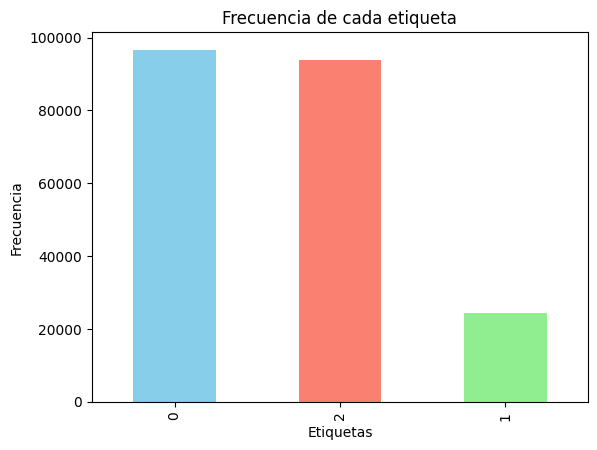

In [44]:
label_counts = df['label'].value_counts()

# Crear el gráfico de barras
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])

# Añadir título y etiquetas
plt.title('Frecuencia de cada etiqueta')
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

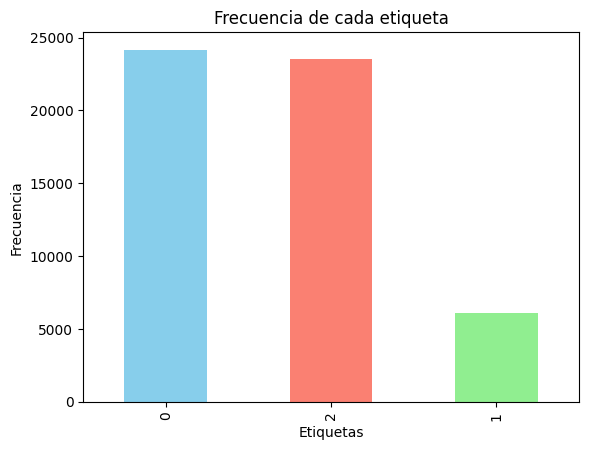

In [45]:
label_counts = test_data['label'].value_counts()

# Crear el gráfico de barras
label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])

# Añadir título y etiquetas
plt.title('Frecuencia de cada etiqueta')
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()